**Movie recommender by: Sepehr Mousaviyan**

# Import required libaries

In [3]:
import os
import pandas as pd
import numpy as np
from google.colab import drive
import seaborn as sns
# ! pip install matplotlib
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import ast
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.snowball import SnowballStemmer
# ! pip install surprise
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

pd.options.display.max_columns=None

import warnings
warnings.simplefilter('ignore')

from datetime import datetime
# ! pip install tensorflow tensorflow_recommenders
import tensorflow as tf
import tensorflow_recommenders as tfrs

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from typing import Dict, Text

In [4]:
# ! pwd
# ! ls drive/MyDrive/Movie_Recommender/archive

# drive.mount('/content/drive')

# def readCSV(name):
#   return pd.read_csv('/content/drive/MyDrive/Movie_Recommender/archive/{}'.format(name))
def readCSV(name):
  return pd.read_csv('{}'.format(name))

In [5]:
md = readCSV('movies_metadata.csv')
links= readCSV('links_small.csv')
credits = readCSV('credits.csv')
keywords = readCSV('keywords.csv')
ratings = readCSV('ratings_small.csv')

FileNotFoundError: ignored

Check missing values

In [ ]:
# print('### md ###')
# print( md.isnull().sum() / len(md) )
# print('\n### links ###')
# print( links.isnull().sum() / len(links) )
# print('\n### credits ###')
# print( credits.isnull().sum() / len(credits) )
# print('\n### keywords ###')
# print( keywords.isnull().sum() / len(keywords) )
# print('\n### ratings ###')
# print( ratings.isnull().sum() / len(ratings) )

In [ ]:
md = md[["id","title","genres","original_language","overview","release_date","vote_average", "vote_count"]]
# credits = credits[["id","cast"]]

In [ ]:
md["id"] = md["id"].astype(str)
md["title"] = md["title"].astype(str)
md["genres"] = md["genres"].astype(str)
md["original_language"] = md["original_language"].astype(str)
md["overview"] = md["overview"].astype(str)
md["release_date"] = md["release_date"].astype(str)
# md.dtypes

In [ ]:
def unpack_genre(x):
    eval_x = literal_eval(x)
    if len(eval_x) == 0:
        return None
    else:
        return [ i['name'] for i in eval_x]
md['genres'] = md.genres.apply(lambda x : unpack_genre(x) )

In [ ]:
def transform_date(x):
    x = x.split("-")[0]
    if x == 'nan':
        return None
    else:
        return x
md["release_date"] = md.release_date.apply(lambda x : transform_date(x) )

In [ ]:
keywords["id"] = keywords["id"].astype(str)
keywords["keywords"] = keywords["keywords"].astype(str)
# keywords.dtypes

In [ ]:
def unpack_keywords(x):
    eval_x = literal_eval(x)
    if len(eval_x) == 0:
        return None
    else:
        return [ i['name'] for i in eval_x]
keywords['keywords'] = keywords.keywords.apply(lambda x : unpack_keywords(x) )

In [ ]:
ratings["userId"] = ratings["userId"].astype(str)
ratings["movieId"] = ratings["movieId"].astype(str)
# ratings.dtypes

In [ ]:
credits["id"] = credits["id"].astype(str)
credits["cast"] = credits["cast"].astype(str)
# credits.dtypes

In [ ]:
# ! pip install pandarallel
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
def unpack_cast(x):
    eval_x = literal_eval(x)
    if len(eval_x) == 0:
        return None
    else:
        return [ i['name'] for i in eval_x]
credits["cast"] = credits.cast.parallel_apply(lambda x : unpack_cast(x) )

In [ ]:
movies = pd.merge(md, keywords, on='id', how='inner')
movies = pd.merge(movies, credits, on='id', how='inner').rename(columns={"id":"movieId"})
movies = movies.dropna(subset=["release_date"])
movies["release_date"] = movies["release_date"].astype('int32')
# movies.head(3)

In [ ]:
movie_ratings = pd.merge( ratings, movies,  on='movieId', how='left')
# movie_ratings.head(3)

# Content based

This approach gives the user movies similar to movie the user have watched.

In [ ]:
links= links[links['tmdbId'].notnull()]['tmdbId'].astype('int')

In [ ]:
# links.head(5)

In [ ]:
md = md.drop([19730, 29503, 35587])

In [ ]:
md['id'] = md['id'].astype('int')

In [ ]:
smd = md[md['id'].isin(links_small)]
# smd.shape

In [ ]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

In [ ]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

In [ ]:
# tfidf_matrix.shape

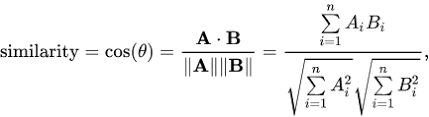

In [ ]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
# cosine_sim[0]

In [ ]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [ ]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [ ]:
get_recommendations('Outbreak').head(20)

Based on meta data

In [ ]:
# credits.head(5)

In [ ]:
# keywords.head(5)

In [ ]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int')
# md.shape

In [ ]:
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

In [ ]:
smd = md[md['id'].isin(links_small)]
smd.shape

In [ ]:
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [ ]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
smd['director'] = smd['crew'].apply(get_director)
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:4] if len(x) >=4 else x)
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [ ]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x,x])

In [ ]:
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [ ]:
s = s.value_counts()
# s[:10]

In [ ]:
s = s[s > 1]

In [ ]:
stemmer = SnowballStemmer('english')
stemmer.stem('sportingly')

In [ ]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [ ]:
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [ ]:
smd['soup'] = smd['keywords']
smd['soup'] = smd['soup'] + smd['cast']
smd['soup'] = smd['soup'] + smd['director']
# smd['soup'] = smd['soup'] + smd['genre']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

In [ ]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [ ]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [ ]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [ ]:
get_recommendations('Memento').head(5)